## Latent Dirichlet Allocation

In [1]:
from octis.models.LDA import LDA
from octis.dataset.dataset import Dataset
from octis.evaluation_metrics.diversity_metrics import TopicDiversity
from octis.evaluation_metrics.coherence_metrics import Coherence
from octis.optimization.optimizer import Optimizer
from skopt.space.space import Integer
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from wordcloud import WordCloud
from tqdm import tqdm

current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
os.chdir(parent_directory)

from utils.graph_tools import word_frequencies_barplot_dict


In [2]:
NUM_ITERS = 15
NUM_OPTIMIZATION_CALLS = 15

In [3]:
dataset = Dataset()
dataset.load_custom_dataset_from_folder('data/processed/dataset')

## Metrics

In [4]:
td, ch = TopicDiversity(topk=10), Coherence(texts = dataset.get_corpus(), topk= 10, measure = 'c_v') # Initialize metrics

## LDA without optimization

In [5]:
# Create Model, our  arbitrary assumption on the initial number of topics: 10 
model = LDA(num_topics=5, alpha = 'auto', passes= 50, iterations = 200, update_every = 1, chunksize = 1000)

In [6]:
coherence_list_no_opt, topic_diversity_list_no_opt, models_no_opt = [], [], []

for i in tqdm(range(NUM_ITERS)):
  output = model.train_model(dataset)
  models_no_opt.append(output)
  coherence_list_no_opt.append(ch_score := ch.score(output))
  topic_diversity_list_no_opt.append(td_score := td.score(output))

print("Mean coherence: ", np.mean(coherence_list_no_opt), "\nMean topic diversity: ", np.mean(topic_diversity_list_no_opt))

100%|██████████| 15/15 [08:51<00:00, 35.41s/it]

Mean coherence:  0.6067265795731097 
Mean topic diversity:  0.8520000000000001


## LDA with optimization

In [7]:
model = LDA(alpha = 'auto', passes= 50, iterations = 200, update_every = 1, chunksize = 1000)

In [8]:
# Optimization for hyperparameters based on coherence

search_space = {"num_topics": Integer(low=5, high=35)}
optimizer=Optimizer()


In [9]:
optResult = optimizer.optimize(model, dataset, ch, search_space, save_path="results/test_LDA", # path to store the results
                            number_of_call = NUM_OPTIMIZATION_CALLS, # number of optimization iterations: rule of thumb 15*num_hyperparameters but takes a lot of time so 30 instead
                            model_runs = 5, # number of runs of the topic model: can be increased but takes more time
                            plot_best_seen = True, # plot the best seen value of the metric
                            extra_metrics = [td], # track also the topic diversity
                            plot_model = True, # plot the topic model
                            early_step = 10, # number of iterations after which the optimization stops if no improvement
                            surrogate_model ='GP', # surrogate model for the optimization: gaussian process
                            save_models = True,
                            topk = 20)


optResult.save_to_csv("results.csv")

results = json.load(open("results/test_LDA/result.json",'r'))

Current call:  0
Current call:  1
Current call:  2
Current call:  3


/home/nicovis/anaconda3/envs/OCTIS/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [5] before, using random point [31]
  warnings.warn(


Current call:  4
Current call:  5


/home/nicovis/anaconda3/envs/OCTIS/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [5] before, using random point [22]
  warnings.warn(


Current call:  6
Current call:  7


/home/nicovis/anaconda3/envs/OCTIS/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [5] before, using random point [32]
  warnings.warn(


Current call:  8


/home/nicovis/anaconda3/envs/OCTIS/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [5] before, using random point [25]
  warnings.warn(


Current call:  9


/home/nicovis/anaconda3/envs/OCTIS/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [5] before, using random point [23]
  warnings.warn(


Current call:  10


/home/nicovis/anaconda3/envs/OCTIS/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [5] before, using random point [23]
  warnings.warn(


Current call:  11


/home/nicovis/anaconda3/envs/OCTIS/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [5] before, using random point [13]
  warnings.warn(


Current call:  12
Current call:  13
Current call:  14


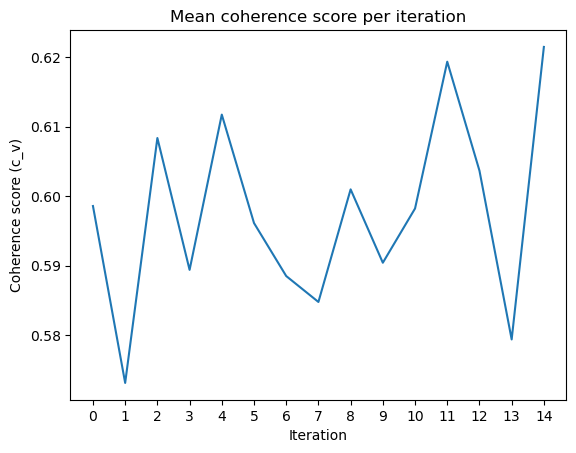

0.6214354554897238


In [10]:
plt.xlabel('Iteration')
plt.ylabel('Coherence score (c_v)')
plt.title('Mean coherence score per iteration')

coherences = results['dict_model_runs']['Coherence']

mean_coherences = [np.mean(coherences[key]) for key in coherences.keys()]

plt.plot(mean_coherences)
plt.xticks(range(len(mean_coherences)))
plt.show()

print(np.max(mean_coherences))

max_index = np.argmax(mean_coherences)

In [11]:
num_topics = results["x_iters"]["num_topics"][max_index]

print("Optimal number of topics: ", num_topics)

Optimal number of topics:  6


Now we're ready to train it. Note that the output of a topic model comes as a dictionary composed of 4 elements:


*   *topics*: the list of word topics
*   *topic-word-matrix*: the distribution of the words of the vocabulary for each topic (dimensions: |num topics| x |vocabulary|)
*   *topic-document-matrix*: the distribution of the topics for each document of the training set (dimensions: |num topics| x |training documents|)
*   *test-document-topic-matrix*: the distribution of the topics for each document of the testing set (dimensions: |num topics| x |test documents|)



In [12]:
model = LDA(num_topics = num_topics, alpha = 'auto', passes= 50, iterations = 200, update_every = 1, chunksize = 1000)

In [13]:
coherence_list, topic_diversity_list, models_opt = [], [], []

for i in tqdm(range(NUM_ITERS)):
  output = model.train_model(dataset, top_words=10)
  models_opt.append(output)
  coherence_list.append(ch_score := ch.score(output))
  topic_diversity_list.append(td_score := td.score(output))


print("Mean coherence: ", np.mean(coherence_list), "\nMean topic diversity: ", np.mean(topic_diversity_list))

100%|██████████| 15/15 [08:39<00:00, 34.66s/it]

Mean coherence:  0.6168058133774331 
Mean topic diversity:  0.8566666666666668


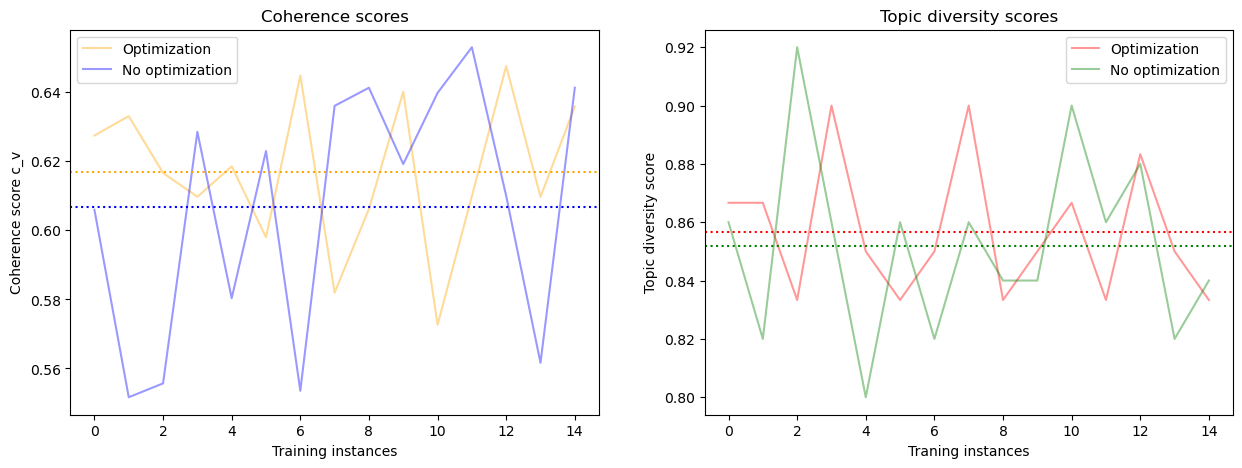

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Coherence scores plot
axs[0].plot(coherence_list, label="Optimization", color = 'orange', alpha = 0.4)
axs[0].plot(coherence_list_no_opt, label="No optimization", color = 'blue', alpha = 0.4)
axs[0].axhline(y=np.mean(coherence_list), color='orange', linestyle=':')
axs[0].axhline(y=np.mean(coherence_list_no_opt), color='blue', linestyle=':')
axs[0].set_title("Coherence scores")
axs[0].set_xlabel("Training instances")
axs[0].set_ylabel("Coherence score c_v")
axs[0].legend()

# Topic diversity scores plot
axs[1].plot(topic_diversity_list, label="Optimization", color = 'r', alpha = 0.4)
axs[1].plot(topic_diversity_list_no_opt, label="No optimization", color = 'g', alpha = 0.4)
axs[1].axhline(y=np.mean(topic_diversity_list), color='r', linestyle=':')
axs[1].axhline(y=np.mean(topic_diversity_list_no_opt), color='g', linestyle=':')
axs[1].set_title("Topic diversity scores")
axs[1].set_xlabel("Traning instances")
axs[1].set_ylabel("Topic diversity score")
axs[1].legend()

plt.show()


In [21]:
best_output = models_opt[np.argmax([coherence_list[i] for i in range(len(coherence_list))])]


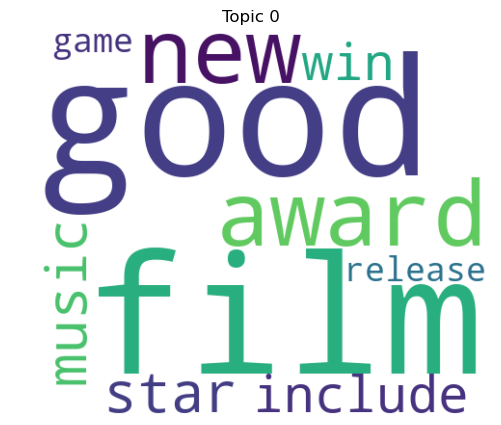

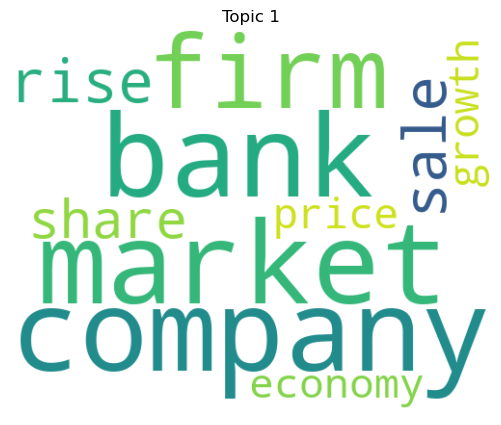

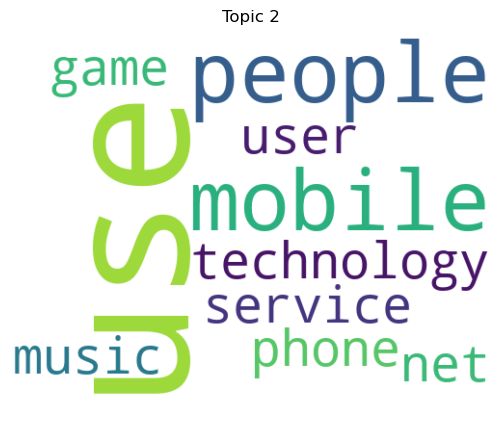

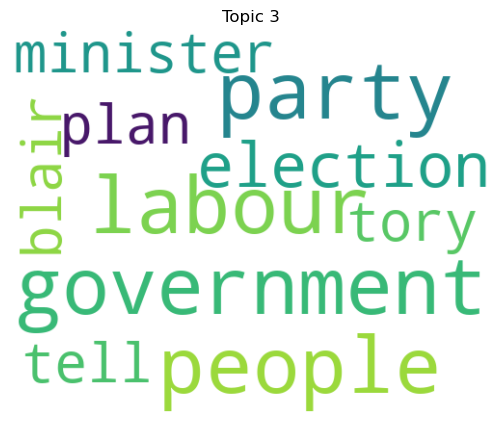

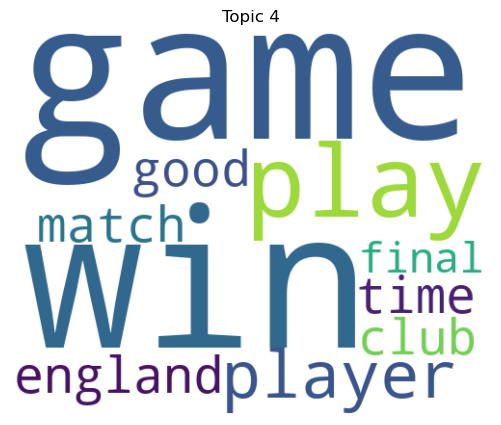

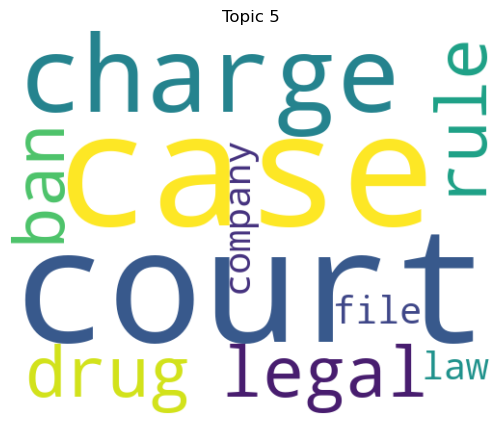

In [22]:
topics = best_output['topics']
for i, topic in enumerate(topics):
  wordcloud = WordCloud(width=500, height=400, background_color='white').generate(" ".join(topic))
  plt.figure(figsize=(10, 5))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.title(f"Topic {i}")
  plt.show()


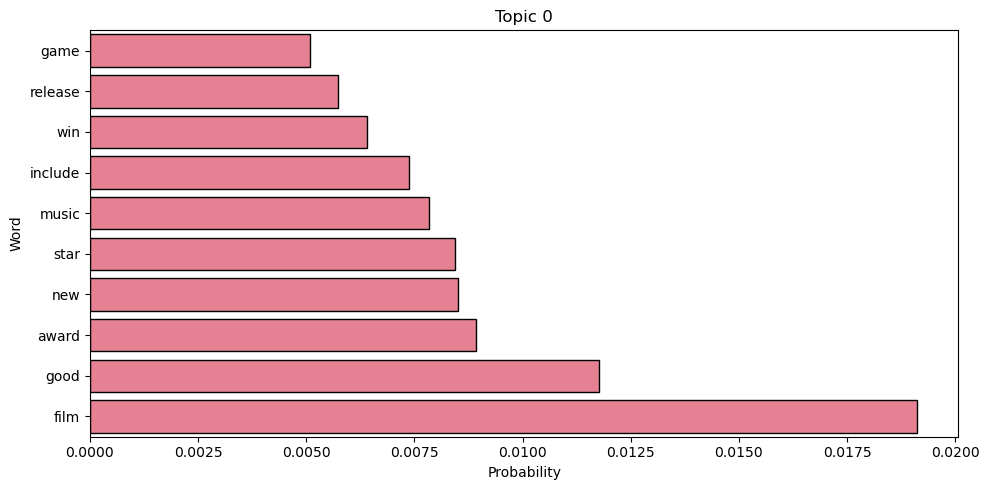

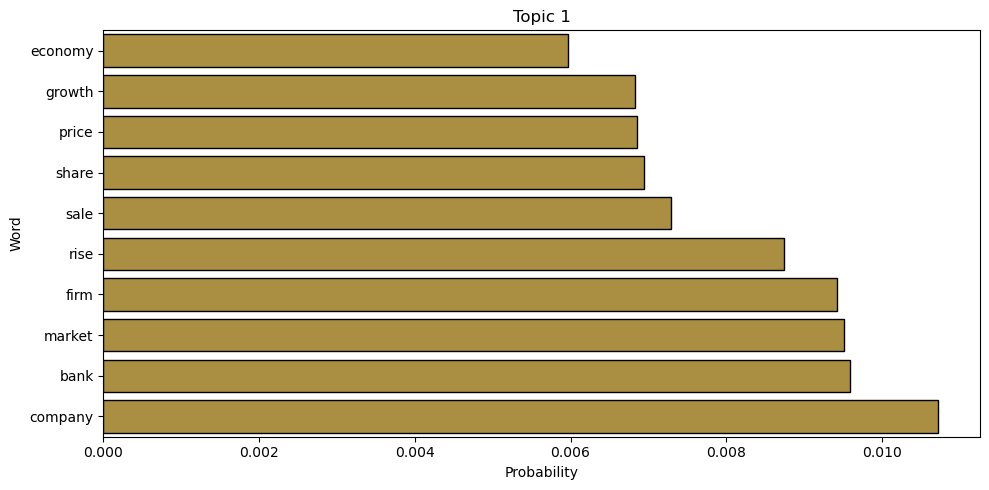

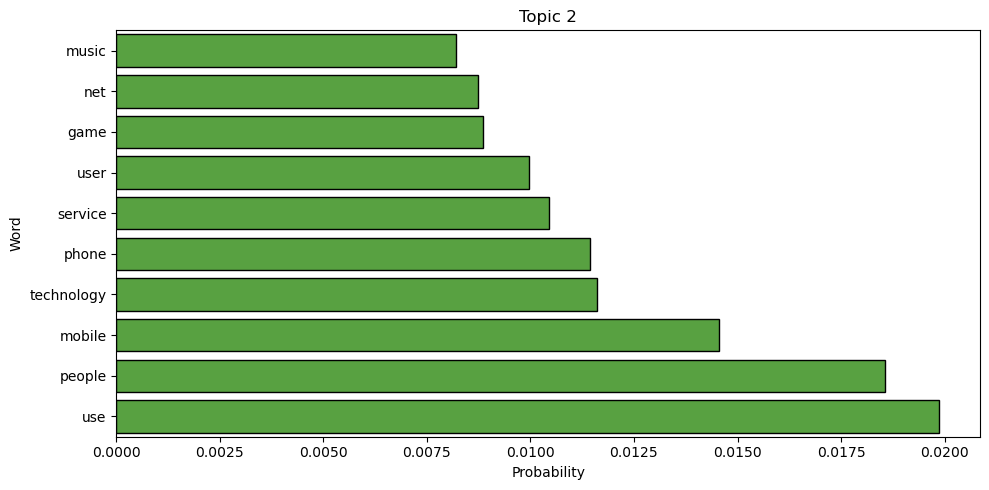

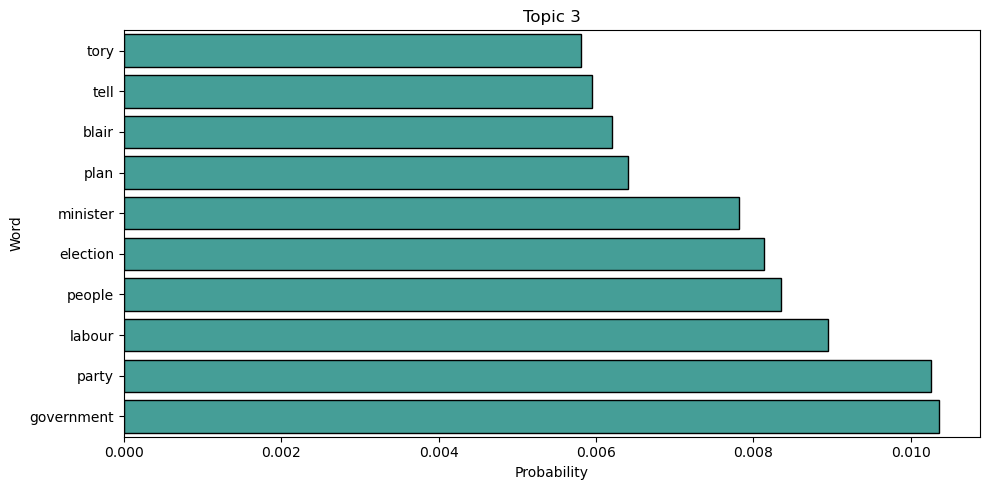

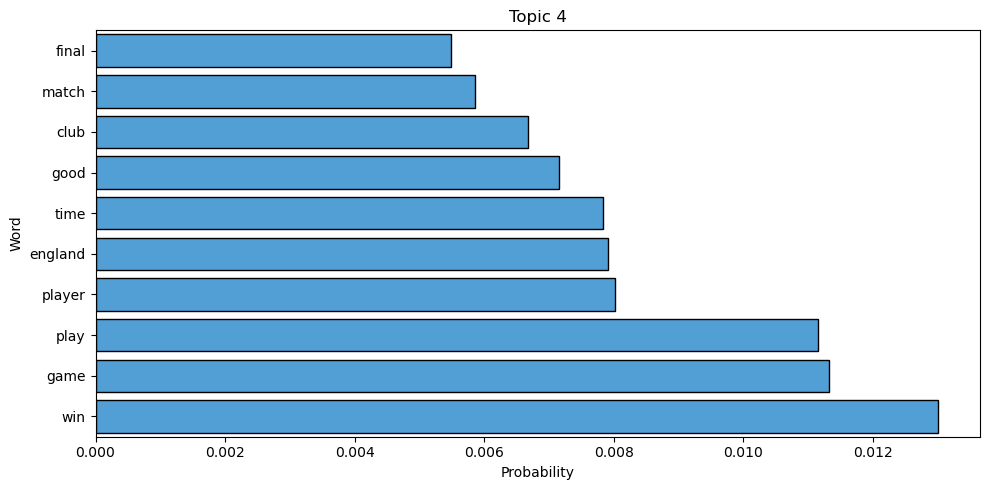

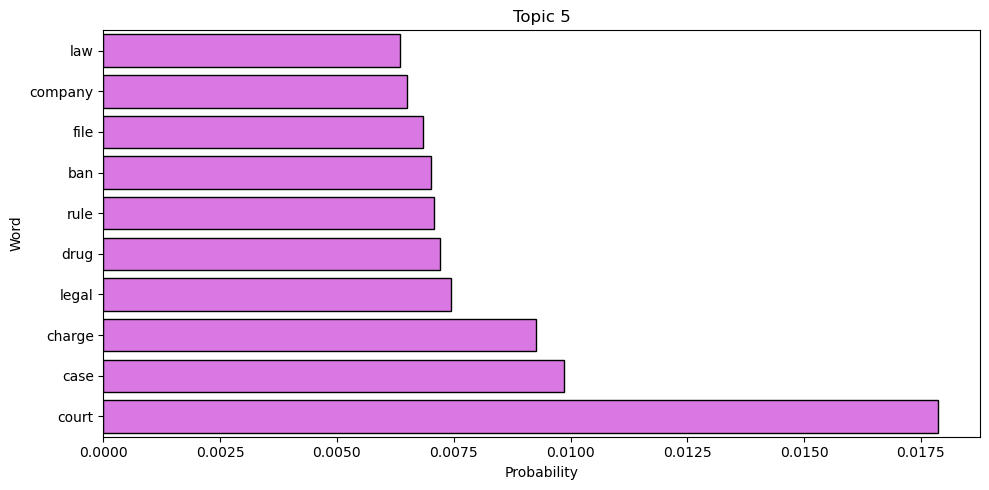

In [23]:
word_frequencies_barplot_dict(best_output)
